# Analysis

In this notebook, we analyze the data that we curated and the results of our experiments. The notebook is organized around the three types of data in the project:

1. Feature data

_This data is curated from both the Universal Dependencies and the UniMorph projects. BERT gives us a distribution over its vocab for the masked out word. In order to know how correct BERT was, we need to know the feature values of those words._

2. Cloze data

_This data comes from the Universal Dependencies project. We mask out a word from these sentences and ask BERT to predict the missing word._

3. Experiental results

_We ask BERT to predict the masked out word and compute whether, on average, BERT assigned a higher probability to words with the correct feature values than words with incorrect feature values. This data holds that information as well as the number of distractors in the sentence and the length between the target and control._

In [14]:
%matplotlib inline
import glob
import os
import sys
sys.path.insert(0, '../src')

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set(font='serif')
sns.set_style("white", {"font.family": "serif","font.serif": ["Times", "Palatino", "serif"]})

from bert import BERT
from constants import LANGUAGES
from experiment import ENGLISH_MODEL, MULTILINGUAL_MODEL
CODE_TO_LANGUAGE = {code: lg for lg, code in LANGUAGES.items()}

FEATURES_FNAMES = glob.glob('../data/features/*.csv')
CLOZE_FNAMES = glob.glob('../data/cloze/*.csv')
EXPERIMENT_FNAMES = glob.glob('../data/experiments/*.csv')

BLUE = sns.color_palette()[0]

## 1. Features

I want to answer the following questions:

1. How many languages did we curate feature data for?
2. How many feature values did we get per language?
3. For each language, how big is the intersection between the feature data we have and the words in BERT's vocab?
4. We allowed for the possibility of a word having no value for a particular feature. How dense are our feature values? I.e. How many words have no value? This is restricted to the words that are in BERT's vocab.
5. Are particular features more sparse than others?

Here are the answers:

1. We curated feature data for 34 languages. The languages are: Afrikaans, Arabic, Armenian, Basque, Breton, Catalan, Croatian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hebrew, Hindi, Hungarian, Irish, Italian, Latin, Norwegian-Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Spanish, Swedish, Tamil, Telugu, Turkish, Ukrainian and Urdu.

2. We got between 182 (Telegu) and 1,212,893 (Finnish) feature values per langauge. The full list of counts is below. The median number per language is 23,774 and the average is 98,783. Finnish has three times as many feature values as the second most well-represented language (Hungarian), which drags the average up so much.

3. For English, we have 6,743 word forms with feature values out of BERT's vocab of 28,996 word forms. This is pretty good coverage considering that we restricted feature values to only nouns and pronouns whereas BERT's vocab has all POS. For the multilingual model, we have a vocab of 119,547 word forms. German has the most word forms with feature values at 4,790. This seems pretty good coverage as well, considering that 104 languages are vying for a shared vocab and we're only looking at nouns and pronouns here. French and Spanish are the next two most well-represented, each with other 3,000 word forms. Telegu has the worst representation, with only a single word form with a feature value in the multilingual data. Tamil is next with 67, then Breton with 157, and Basque, Irish, Armenian and Greek all have between 200-300 word forms. In this experimental setup we're making an assumption that words with idential POS and these four feature values are always grammatical replacements for one another. We don't take into account selection restrictions, either syntactic or semantic. To make this assumption as palatable as possible, we want to have a decent number of words with feature values. **We clearly need to drop Telegu from the analysis.** Note that this answer is counting unique word _forms_, so words with multiple feature bundles are only counted once.

4. I started answering this question (and the code is still in place to continue answering it) but I realized that we don't care about the density of the individual features but rather the number of correct/incorrect words for each cloze example. Knowing that the feature data for a language has many singular words isn't what I want to know, because perhaps there are many singular words but all of them are masculine and my cloze example requires a singular feminine word. What we want to know is, for each cloze examples, how many correct and incorrect words (that I have features on) did BERT have the opportunity to predict. If I only have data on three singular feminine words but many many singular masculine words in a particular language and a cloze example expected the feminine form, it could be unfair to include that example. Such an approach will also handle the Telegu case and allow me to set a consistent threshold across languages.

5. This has a similar response to above.

Note that we restricted the feature data to only include nouns and pronouns, because these are the only POS that we are predicting in these experiments. That is the case because we decided to always predict the controller of the agreement, not the target. 

In [15]:
# Read in the feature data
features = []
for fname in FEATURES_FNAMES:
    fts = pd.read_csv(fname, index_col=0, dtype={'person': str})
    code = fname[-7:-4]
    language = CODE_TO_LANGUAGE[code]
    fts['language'] = language
    features.append(fts)
features = pd.concat(features, sort=False)
features = features[features['pos'].isin(['NOUN', 'PRON'])]
features.reset_index(inplace=True)
features.head()

,word,pos,number,gender,case,person,language
0,világban,NOUN,Sing,NO VALUE,NO VALUE,NO VALUE,Hungarian
1,éve,NOUN,Sing,NO VALUE,Nom,NO VALUE,Hungarian
2,fellendülés,NOUN,Sing,NO VALUE,Nom,NO VALUE,Hungarian
3,konjunktúra-időszaknál,NOUN,Sing,NO VALUE,NO VALUE,NO VALUE,Hungarian
4,gazdaság,NOUN,Sing,NO VALUE,Nom,NO VALUE,Hungarian


In [16]:
# 1. How many languages did we curate feature data for?
print(len(features['language'].unique()))
', '.join(sorted(features['language'].unique()))

34


'Afrikaans, Arabic, Armenian, Basque, Breton, Catalan, Croatian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hebrew, Hindi, Hungarian, Irish, Italian, Latin, Norwegian-Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Spanish, Swedish, Tamil, Telugu, Turkish, Ukrainian, Urdu'

In [17]:
# 2. How many feature values did we get per language?
features['language'].value_counts()

Finnish              1212893
Hungarian             415512
Russian               237988
German                233709
Turkish               181682
Armenian              153487
Polish                119716
Czech                 103709
Latin                 101591
Greek                  84566
Irish                  79368
Arabic                 69001
Swedish                62090
Romanian               41440
Danish                 33136
Ukrainian              30945
Norwegian-Nynorsk      29530
Spanish                18019
Hindi                  15035
Croatian               15028
Dutch                  15001
French                 14993
Italian                14312
English                12881
Hebrew                 10439
Persian                 9898
Catalan                 9591
Portuguese              9582
Urdu                    9315
Basque                  8225
Afrikaans               3206
Tamil                   1466
Breton                  1083
Telugu                   182
Name: language

In [18]:
features['language'].value_counts().describe().apply(lambda n: format(n, 'f'))

count         34.000000
mean       98782.911765
std       216311.105461
min          182.000000
25%        10033.250000
50%        23774.500000
75%        97334.750000
max      1212893.000000
Name: language, dtype: object

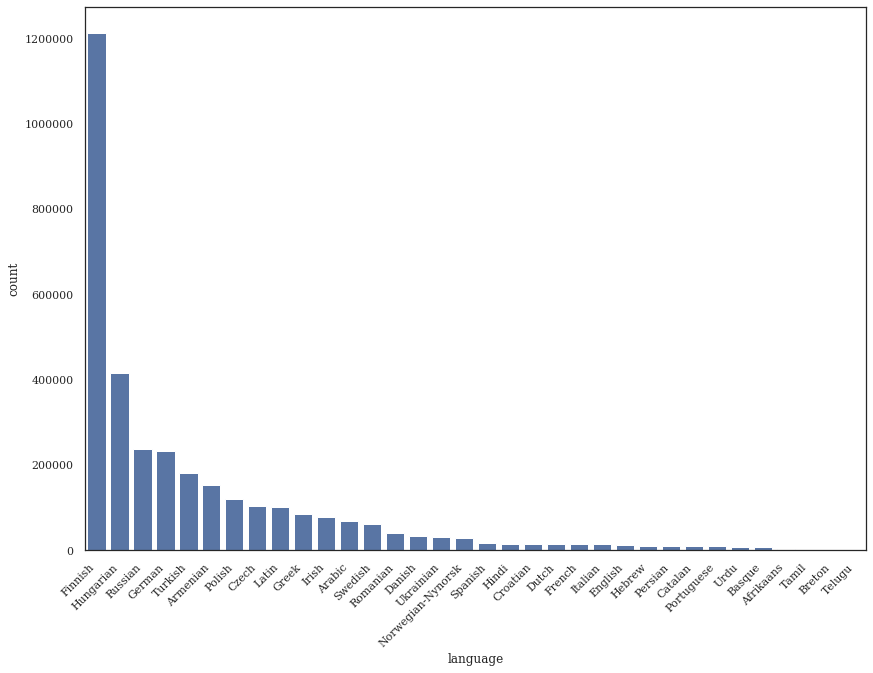

In [19]:
# Visualize the number of feature data points per language
def countplot(series, figsize=(14, 10)):
    """Helper function to visualize a pd.Series as a countplot."""
    plt.figure(figsize=figsize)
    order = series.value_counts().index
    plot = sns.countplot(series, color=BLUE, order=order)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right');

countplot(features['language'])

In [20]:
# 3. For each language, how big is the intersection between the feature data we have and the words in BERT's vocab?
# We first compute this for the single language English model.
bert = BERT(ENGLISH_MODEL)
# although we use the cased models, we lowercase the vocab in the experiment to increase our vocab coverage. This 
# assumes that the feature values of a word do not change depending on its casing, which is an assumption I'm pretty 
# comfortable making. 
english_vocab = [word.lower() for word in bert.vocab]
print("Size of English BERT's vocab: ", len(english_vocab))
english_features = features[features['language'] == 'English'].copy()
english_features['in_vocab'] = english_features['word'].isin(english_vocab)
counts = english_features.drop_duplicates(subset=['word'])['in_vocab'].value_counts()
print("Size of English BERT's vocab with feature values:", counts[True])

Size of English BERT's vocab:  28996
Size of English BERT's vocab with feature values: 6743


In [21]:
# Now we compute this for all other languages with the multilingual model.
bert = BERT(MULTILINGUAL_MODEL)
multilingual_vocab = [word.lower() for word in bert.vocab]
print("Size of multilingual BERT's vocab: ", len(multilingual_vocab))
multilingual_features = features[features['language'] != 'English'].copy()
multilingual_features['in_vocab'] = multilingual_features['word'].isin(multilingual_vocab)
counts = (multilingual_features.drop_duplicates(subset=['word', 'language'])
          .groupby('language')['in_vocab']
          .value_counts()
          .to_frame(name='count')
          .reset_index())
counts = counts[counts['in_vocab']]
counts.sort_values(by='count', ascending=False).head()

Size of multilingual BERT's vocab:  119547


,language,in_vocab,count
25,German,True,4790
23,French,True,3384
53,Spanish,True,3225
37,Italian,True,2479
51,Russian,True,2404


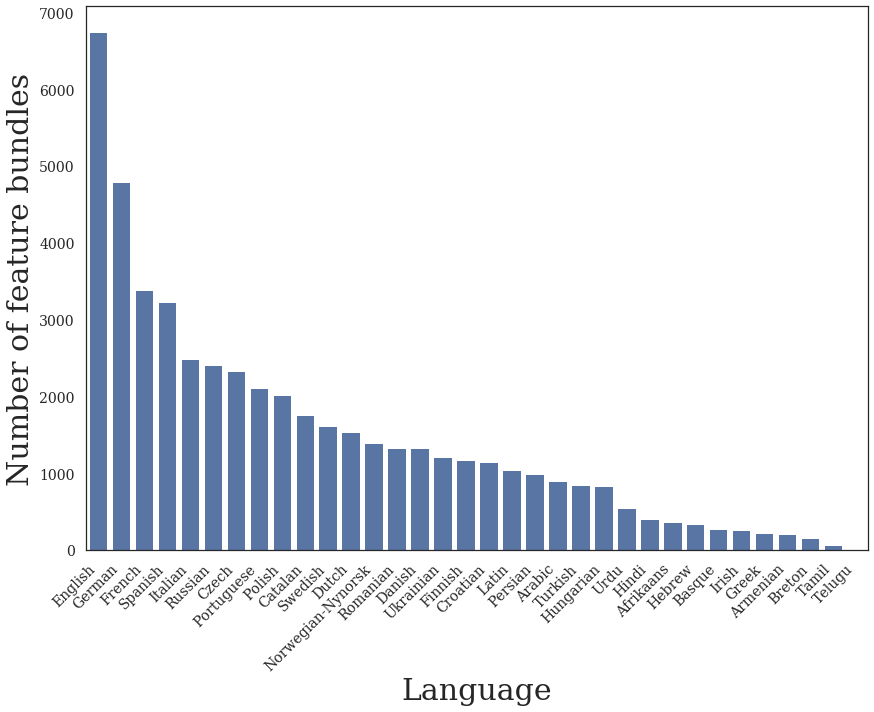

In [22]:
# Visualize the size of overlap between feature data and BERT's vocab
def barplot(df, x, y, figsize=(14, 10)):
    """Helper function to plot a barplot"""
    plt.figure(figsize=figsize)
    order = df.sort_values(by=y, ascending=False)[x]
    plot = sns.barplot(x=x, y=y, data=df, color=BLUE, order=order);
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right');
    return plot

# Add in English data
if "English" not in list(counts["language"]):
    counts = counts.append({'language': 'English', 'in_vocab': True, 'count': 6743}, ignore_index=True)
plot = barplot(counts, 'language', 'count');
fontsize = 30
plt.xlabel("Language", fontsize=fontsize)
plt.ylabel("Number of feature bundles", fontsize=fontsize)
plt.tick_params(labelsize=14)

In [23]:
counts.sort_values(by='count', ascending=False)

,language,in_vocab,count
33,English,True,6743
12,German,True,4790
11,French,True,3384
26,Spanish,True,3225
18,Italian,True,2479
25,Russian,True,2404
7,Czech,True,2328
23,Portuguese,True,2107
22,Polish,True,2011
5,Catalan,True,1753


In [24]:
# 4. We allowed for the possibility of a word having no value for a particular feature. How dense are our
# feature values? I.e. How many words have no value? This is restricted to the words that are in BERT's vocab.
in_vocab_features = pd.concat([english_features, multilingual_features], ignore_index=True, sort=False)
in_vocab_features = in_vocab_features[in_vocab_features['in_vocab']]

# hard-code order of feature values
order = {'number': ['Sing', 'Plur', 'NO VALUE'],
         'gender': ['Fem', 'Masc', 'Neut', 'NO VALUE'],
         'person': ['1', '2', '3', 'NO VALUE'],
         'case': ['Nom', 'Acc', 'Abs', 'Erg', 'NO VALUE']}

def plot_feature_density(df, feature):
    """Helper function for plotting the density of feature values in `df`."""
    df.sort_values(by='language', inplace=True)  # order by language alphabetically
    values = order[feature]
    g = sns.FacetGrid(data=df, col='language', col_wrap=4, sharey=False)
    g = g.map(sns.countplot, feature, order=values)
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), visible=True);

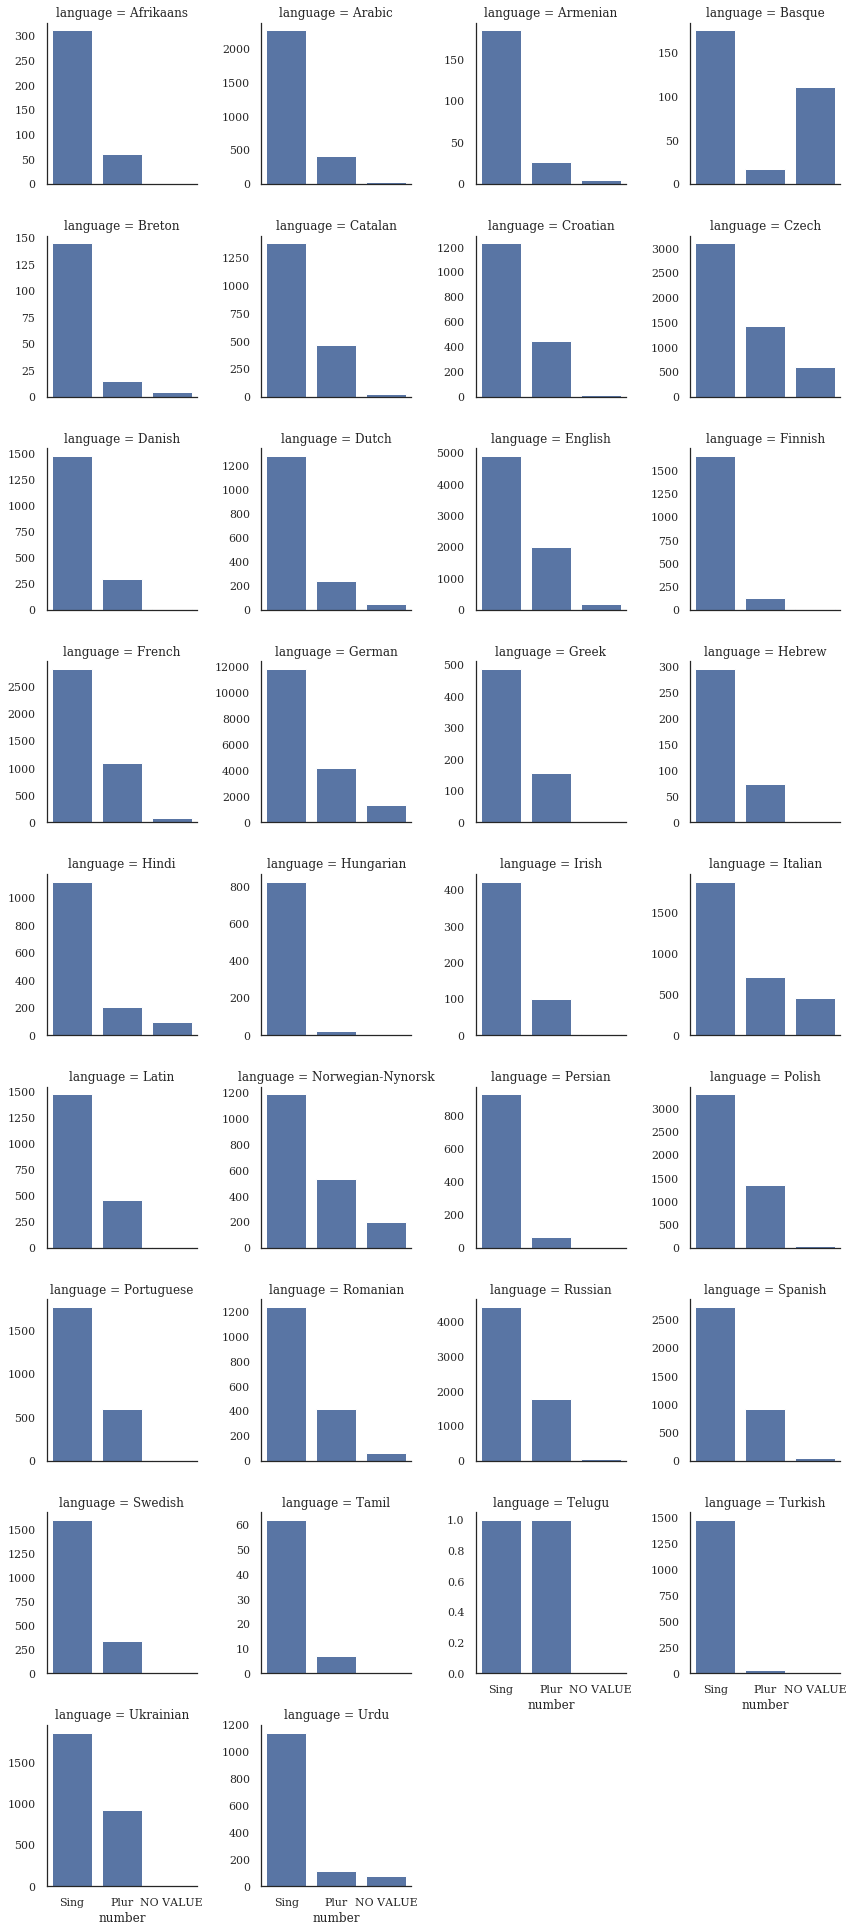

In [25]:
# We first compute the density of the number feature
# Armenian only has ~25 plural words, Basque ~15, Breton ~15, Hungarian ~20, Persian ~30, Tamil 8, Telegu 1,
# Turkish 33
plot_feature_density(in_vocab_features, 'number')

We could continue plotting the feature densities for the remaining three features, but it's at this point I realized that we don't want to know the density of individual features in the dataset. We're using an "all-or-none" approach in which a word is only correct if all four feature values are correct. So what we care about is the number of words that are correct and incorrect words for each cloze example. If an example doesn't have many possible correct words, then we might consider dropping it.

## Cloze

I want to answer the following questions:

1. How many cloze examples do we have in total?
2. How many languages do we have cloze examples for?
3. How many examples did we get per language?
4. What is the distribution of types i) in the entire dataset, and ii) per language?
5. What is the distribution of POS i) in the entire dataset, and ii) per language?
6. For each cloze example, how many correct and incorrect words with features do we have?
7. What is the distribution of intervening nouns and the number of distractors per language?
8. What is the distribution of the lengths of the sentences (including the "mask" token)?

Here are the answers:

1. We have 2,089,557 cloze examples in total.
2. We have 33 languages with cloze examples. They are: Afrikaans, Arabic, Armenian, Basque, Breton, Catalan, Croatian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hebrew, Hindi, Hungarian, Irish, Italian, Latin, Norwegian-Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Spanish, Swedish, Tamil, Turkish, Ukrainian and Urdu. We had 34 languages with features, and the missing language is Telegu.
3. We got between 637,428 for German and 193 for Hungarian. The average was 63,319 and the median 22,959. German really drags up the average, as the next most well-represented languages are Czech (270,034), Spanish (176,138), Russian (144,458), Italian (137,268) and French (117,769) which all have over 100,000. Tamil (909), Breton (263) and Hungarian (193) all have less than 1,000 examples. **We may want to drop Tamil, Breton and Hungarian.**
4. We have 774,038 examples of modifying adjectives, 771,806 of determiners, 494,205 of nouns and 49,508 of predicated adjectives. There's a nice table below showing the counts per type for each language, which I think is the best way to display this information. The plots are not as helpful in my opinion.
5. We have 1,934,950 nouns and 154,607 pronouns in our data, so overwhelmingly nouns. A similar table is shown below.
6. The average number of correct words was 572 and the average number of incorrect words was 6,412. The median numbers were 418 and 15,783. Some cloze examples have 1 or only a handful of correct examples, in which case **we should not count these examples.**
7. The answer is below but I'm not sure I see any immediate relevance.
8. Again, the answer is below but I don't think it's immediate relevant.

In [26]:
# Read in the cloze data
cloze = []
for fname in CLOZE_FNAMES:
    cl = pd.read_csv(fname, index_col=0, dtype={'person': str, 'num_distractors': int})
    code = fname[-7:-4]
    language = CODE_TO_LANGUAGE[code]
    cl['language'] = language
    cloze.append(cl)
cloze = pd.concat(cloze, sort=False)
cloze.reset_index(inplace=True)
cloze.head()

,uid,type,pos,number,gender,case,person,masked,other_masked,intervening_noun,num_distractors,language
0,dev-s1,modifying,NOUN,Plur,NO VALUE,NO VALUE,NO VALUE,En ons hoop hierdie keer dat hernude [MASK] de...,En ons hoop hierdie keer dat [MASK] pogings de...,False,7,Afrikaans
1,dev-s1,modifying,NOUN,Sing,NO VALUE,NO VALUE,NO VALUE,En ons hoop hierdie keer dat hernude pogings d...,En ons hoop hierdie keer dat hernude pogings d...,False,5,Afrikaans
2,dev-s1,modifying,NOUN,Plur,NO VALUE,NO VALUE,NO VALUE,En ons hoop hierdie keer dat hernude pogings d...,En ons hoop hierdie keer dat hernude pogings d...,False,7,Afrikaans
3,dev-s1,modifying,NOUN,Plur,NO VALUE,NO VALUE,NO VALUE,En ons hoop hierdie keer dat hernude pogings d...,En ons hoop hierdie keer dat hernude pogings d...,False,7,Afrikaans
4,dev-s2,modifying,NOUN,Sing,NO VALUE,NO VALUE,NO VALUE,Ons spesiale [MASK] gaan aan die Regering en m...,Ons [MASK] gelukwensing gaan aan die Regering ...,False,6,Afrikaans


In [27]:
# 1. How many cloze examples do we have in total?
len(cloze)

2089341

In [28]:
# 2. How many languages do we have cloze examples for?
print(len(cloze['language'].unique()))
', '.join(sorted(cloze['language'].unique()))

33


'Afrikaans, Arabic, Armenian, Basque, Breton, Catalan, Croatian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hebrew, Hindi, Hungarian, Irish, Italian, Latin, Norwegian-Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Spanish, Swedish, Tamil, Turkish, Ukrainian, Urdu'

In [29]:
# Which language(s) are in the feature data but not in the cloze data?
set(features['language'].unique()).difference(set(cloze['language'].unique()))

{'Telugu'}

In [30]:
# 3. How many examples did we get per language?
cloze['language'].value_counts()

German               637428
Czech                269522
Spanish              176138
Russian              144458
Italian              137268
French               117769
Catalan               88053
English               60060
Dutch                 52569
Latin                 49977
Polish                47513
Portuguese            47038
Finnish               36705
Romanian              29770
Norwegian-Nynorsk     29059
Arabic                23999
Hindi                 23032
Croatian              21835
Persian               14238
Greek                 14017
Ukrainian             13929
Hebrew                11085
Swedish               10889
Danish                 9432
Urdu                   8138
Basque                 4132
Turkish                3155
Irish                  3030
Afrikaans              2304
Armenian               1434
Tamil                   909
Breton                  263
Hungarian               193
Name: language, dtype: int64

In [31]:
cloze['language'].value_counts().describe()

count        33.000000
mean      63313.363636
std      119643.400511
min         193.000000
25%        8138.000000
50%       23032.000000
75%       52569.000000
max      637428.000000
Name: language, dtype: float64

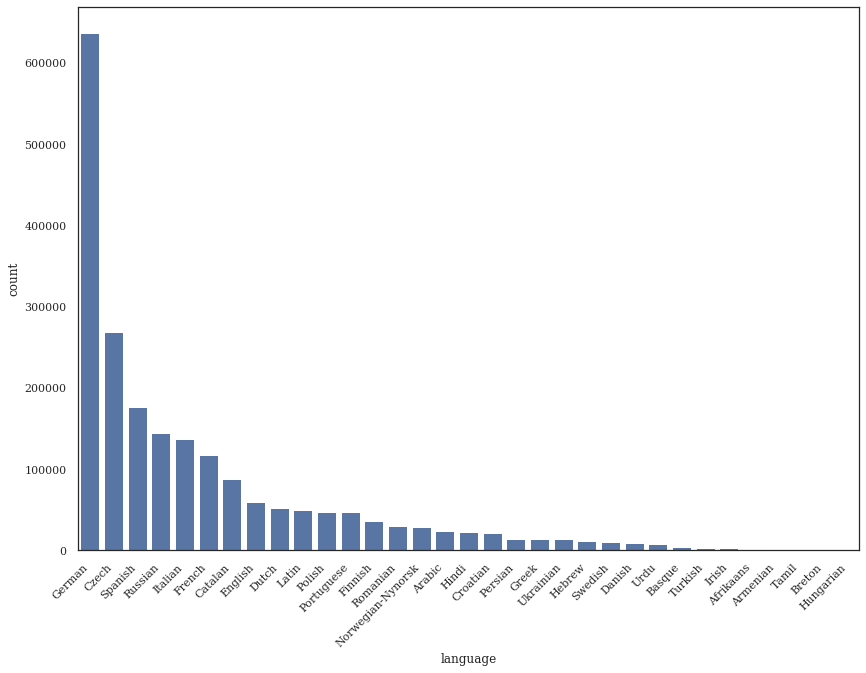

In [32]:
# Visualize the number of cloze examples per language
countplot(cloze['language']);

In [33]:
# 4. What is the distribution of types i) in the entire dataset, and ii) per language?
# We start with the entire dataset
cloze['type'].value_counts()

modifying     774027
determiner    771751
verb          494119
predicated     49444
Name: type, dtype: int64

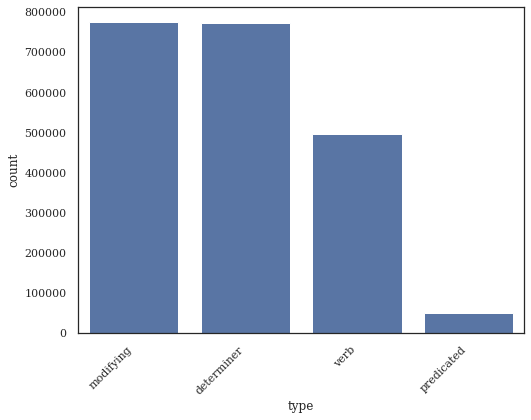

In [34]:
countplot(cloze['type'], figsize=(8, 6));

In [35]:
# Now we split by language
types = cloze.groupby('language')['type'].value_counts().to_frame('count').reset_index()
types.head()

,language,type,count
0,Afrikaans,modifying,2304
1,Arabic,modifying,15170
2,Arabic,verb,8532
3,Arabic,predicated,297
4,Armenian,verb,1434


In [36]:
pivoted_types = types.pivot(index='language', columns='type', values='count')
pivoted_types.fillna('-', inplace=True)
pivoted_types.head()

type,determiner,modifying,predicated,verb
language,,,,
Afrikaans,-,2304,-,-
Arabic,-,15170,297,8532
Armenian,-,-,-,1434
Basque,211,440,216,3265
Breton,-,-,-,263


In [37]:
# 5. What is the distribution of POS i) in the entire dataset, and ii) per language?
# We start with the entire dataset
cloze['pos'].value_counts()

NOUN    1934868
PRON     154473
Name: pos, dtype: int64

In [38]:
# Now we split by language
pos = cloze.groupby('language')['pos'].value_counts().to_frame('count').reset_index()
pivoted_pos = pos.pivot(index='language', columns='pos', values='count')
pivoted_pos.fillna('-', inplace=True)
pivoted_pos['NOUN'] = pivoted_pos['NOUN'].astype(int)
pivoted_pos.head()

pos,NOUN,PRON
language,,
Afrikaans,2304,-
Arabic,23106,893
Armenian,958,476
Basque,4074,58
Breton,232,31


In [39]:
# 6. For each cloze example, how many correct and incorrect words with features do we have?
group_cols = ['language', 'pos']
feature_cols = ['number', 'gender', 'case', 'person']
types = cloze.drop_duplicates(subset=group_cols+feature_cols)
types = types.merge(in_vocab_features, how='left', on=group_cols, suffixes=('', '_'))
vocab_feature_cols = [f + '_' for f in feature_cols]
vocab_features = types[vocab_feature_cols].copy()
vocab_features.columns = feature_cols
types['correct'] = (types[feature_cols] == vocab_features).all(axis=1)
counts = (types.groupby(group_cols+feature_cols)['correct']
           .value_counts()
           .to_frame('count')
           .reset_index())
correct = cloze.merge(counts, how='left', on=group_cols+feature_cols)
correct.groupby('correct')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
correct,,,,,,,,
False,2089341.0,6413.409465,6201.779576,2.0,1629.0,3422.0,15783.0,16677.0
True,2063464.0,576.962705,685.823222,1.0,170.0,444.0,760.0,4793.0


In [40]:
# This is a second way of calculating the numbers of correct and incorrect words with features
# I cannot think of a better name than "numbers" at the moment :S

In [41]:
group_cols = ['language', 'pos']
feature_cols = ['number', 'gender', 'case', 'person']
num_correct = in_vocab_features.groupby(group_cols+feature_cols).size().to_frame('num_correct').reset_index()
num_total = in_vocab_features.groupby(group_cols).size().to_frame('num_total')
numbers = num_correct.merge(num_total, on=group_cols, how='left')
numbers['num_incorrect'] = numbers['num_total'] - numbers['num_correct']
numbers.head()

,language,pos,number,gender,case,person,num_correct,num_total,num_incorrect
0,Afrikaans,NOUN,Plur,NO VALUE,NO VALUE,NO VALUE,56,352,296
1,Afrikaans,NOUN,Sing,NO VALUE,NO VALUE,NO VALUE,296,352,56
2,Afrikaans,PRON,Plur,NO VALUE,Acc,1,1,20,19
3,Afrikaans,PRON,Plur,NO VALUE,Acc,3,1,20,19
4,Afrikaans,PRON,Plur,NO VALUE,NO VALUE,1,1,20,19


In [42]:
numbers['num_total'].describe()

count     1503.000000
mean      1468.495675
std       3304.628428
min          2.000000
25%        113.000000
50%        268.000000
75%       1146.000000
max      16677.000000
Name: num_total, dtype: float64

In [43]:
# 7. What is the distribution of intervening nouns and the number of distractors per language?
# We first start with the number of distractors
distractors = cloze.groupby('language')['num_distractors'].value_counts().to_frame('count').reset_index()
distractors.head()

,language,num_distractors,count
0,Afrikaans,2,383
1,Afrikaans,3,347
2,Afrikaans,5,322
3,Afrikaans,4,321
4,Afrikaans,6,221


In [44]:
# Now we calculate the intervening nouns
intervening = cloze.groupby('language')['intervening_noun'].value_counts().to_frame('count').reset_index()
intervening.head()

,language,intervening_noun,count
0,Afrikaans,False,2295
1,Afrikaans,True,9
2,Arabic,False,23665
3,Arabic,True,334
4,Armenian,False,1385


In [45]:
# 8. What is the distribution of the lengths of the sentences (including the "mask" token)?
cloze['length'] = cloze['masked'].str.len()
cloze.groupby('language')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
Afrikaans,2304.0,197.082465,96.110667,22.0,127.0,178.0,246.00,575.0
Arabic,23996.0,251.697241,160.245026,14.0,147.0,215.0,315.00,1676.0
Armenian,1434.0,180.820781,130.442371,12.0,91.0,147.0,228.75,651.0
Basque,4132.0,105.978219,49.666572,13.0,70.0,99.0,135.00,405.0
Breton,263.0,74.346008,38.104793,21.0,45.0,65.0,97.00,212.0
Catalan,88053.0,212.353333,101.546207,11.0,141.0,199.0,268.00,1316.0
Croatian,21835.0,168.561896,81.332476,16.0,112.0,158.0,212.00,947.0
Czech,269522.0,158.059732,151.123169,9.0,93.0,135.0,189.00,3520.0
Danish,9432.0,143.993533,76.216460,9.0,87.0,132.0,187.00,520.0


## Experiments

I want to answer the following questions:

1. How many languages do we have results on so far?
2. How many cloze examples did we have to skip per language?
3. At the highest level, how well does BERT do on this task? What about when we restrict to cloze examples with enough correct/incorrect words?
4. How well does BERT do on each type of agreement?
5. How well does BERT do on each language?
6. What is the distribution of distance i) per type and ii) per language?
7. What is the distribution of number of distractors i) per type and ii) per language?
8. What is the relationship between BERT's performance and distance/number of distractors?

Here are the answers:

1. So far we have results from 29 languages. The missing languages are German, Czech, Spanish and Arabic. We went in reverse order of size of cloze dataset, so we should have got Arabic results because we have results from languages with more cloze examples. This suggests that there was some error that got handled that skipped Arabic. **I should look into this and re-run Arabic.**
2. We most likely skipped cloze examples because we couldn't find the mask token in the masked sentence, which is a bug in the creation of the cloze data. We skipped 4,170 French examples, which is not too troubling because we have over 100,000 French examples, but it would be nice to have them back. We only lost a handful of examples from a handful of other languages, so I'm not worried about this.
3. BERT got 93.5% of the cloze examples correct (without regard to number of correct/incorrect examples). When we restrict the analysis to the examples that meet some threshold for number of correct/incorrect examples, the number is basically the same: 94.2%.
4. BERT does well on all types of agreement, with all types scoring above 90%. It performs best on determiners and modifying adjectives, while worst on predicated adjectives and verbs. This makes sense, as there is normally larger distances between the target and controller in the latter two types than in the first two. When we restrict by the threshold the results do not change.
5. The plots below show how well BERT does on each language for the dataset I curated. Overall, it looks like BERT performs well for the majority of languages, but that there are some languages fare much worse than others. For example, Breton and Hungarian have less than 50% accuracy (although we said we'd drop these languages because they have too few examples). The problem with looking at these results is that even though the datasets were curated using the same methodology, the datasets will be different and not comparable. Perhaps the examples that I have for Breton are just much harder than they are for Portuguese.
6. Most (75%) cloze examples have at most three tokens between the target and controller. This is consistent across types and languages, although the slicing by language is messy because they are so many languages. The English plot is a good example, and Turkisk shows the same overall shape. As you would expect, the average distance is higher for predicated adjectives and verbs than determiners and modifying adjectives.
7. Most (75%) have less than four distractors.
8. The plot belows shows that, aggregating across all languages and types, as the distance between the target and controller increases, BERT's performance decreases slightly. It's important to note that this decrease is not that big. The drop off for number of distractors starts later but drops more radidly once it starts. One way to read this is that BERT is robust to a few distractors but still gets confused when there's too many distractors. When we split by type, it's clear that modifying adjectives drop off much more than the other types, and verbs to a more reduced amount. Overall, the results suggest that BERT is pretty robust to distance and distractors across all languages and types but that modifying adjectives and verbs perform worst.


Note that I have dropped three languages (Tamil, Breton and Hungarian) for having fewer than 1,000 cloze examples and these results come from restricting to cloze examples with enough data.

In [121]:
# Read in the experimental data
experiments = []
for fname in EXPERIMENT_FNAMES:
    ex = pd.read_csv(fname, index_col=0, dtype={'person': str, 'num_distractors': int})
    code = fname[-7:-4]
    language = CODE_TO_LANGUAGE[code]
    ex['language'] = language
    experiments.append(ex)
experiments = pd.concat(experiments, sort=False)
experiments.reset_index(inplace=True)
experiments.head(2)

,uid,type,pos,number,gender,case,person,masked,other_masked,intervening_noun,num_distractors,correct,incorrect,distance,right,language
0,dev-26,predicated,NOUN,Sing,NO VALUE,Nom,NO VALUE,Érdeklődésünkre Buza kijelentette : a kisgazdá...,Érdeklődésünkre Buza kijelentette : a kisgazdá...,True,3,0.073885,0.658768,11,False,Hungarian
1,dev-39,predicated,PRON,Sing,NO VALUE,Nom,3,"[MASK] sem szabályozott , hogy a képen rögzíte...","Az sem [MASK] , hogy a képen rögzített személy...",False,1,4.846125,4.165935,2,True,Hungarian


In [122]:
# 1. How many languages do we have results on so far?
print(len(experiments['language'].unique()))
missing = set(cloze['language'].unique()).difference(experiments['language'].unique())
missing

29


{'Arabic', 'Czech', 'German', 'Spanish'}

In [123]:
# 2. How many cloze examples did we have to skip per language?
num_cloze = cloze['language'].value_counts()
num_experiments = experiments['language'].value_counts()
difference = (num_cloze - num_experiments).to_frame('count')
difference[difference['count'] > 0]

,count
Finnish,20.0
French,4170.0
Hebrew,711.0
Hindi,1.0
Irish,40.0
Latin,62.0


In [124]:
# Here we drop Tamil, Breton and Hungarian for having fewer than 1,000 cloze examples.
lgs_to_drop = ['Tamil', 'Breton', 'Hungarian']
experiments = experiments[~experiments['language'].isin(lgs_to_drop)]

In [125]:
# 3. At the highest level, how well does BERT do on this task?
# We can simply ask for the total accuracy of BERT on the cloze task. This will give us a single number that
# summarizes BERT's performance
experiments['right'].value_counts(normalize=True)

True     0.936385
False    0.063615
Name: right, dtype: float64

In [126]:
# Now we restrict this analysis to cloze examples in which we had above some threshold of correct/incorrect answers.
# The threshold has been set at 10 words each. This will almost surely be too high for all pronouns, so perhaps I'll
# need to revisit this threshold mechanism.
threshold_correct = 10
threshold_incorrect = 10
enough_correct = (numbers['num_correct'] > threshold_correct)
enough_incorrect = (numbers['num_incorrect'] > threshold_incorrect)
numbers['above_threshold'] = enough_correct & enough_incorrect
subset = numbers[group_cols+feature_cols+['above_threshold']]
experiments = experiments.merge(subset, on=group_cols+feature_cols)

In [127]:
# Accuracy when restricted to examples with enough data
above_threshold = experiments[experiments['above_threshold']]
above_threshold['right'].value_counts(normalize=True)

True     0.942675
False    0.057325
Name: right, dtype: float64

In [128]:
# Here I filter out all cloze examples that don't have enough data
experiments = experiments[experiments['above_threshold']]

In [129]:
# 4. How well does BERT do on each type of agreement?
results_by_type = (experiments.groupby('type')['right']
                   .value_counts(normalize=True)
                   .to_frame('proportion')
                   .reset_index())
results_by_type

,type,right,proportion
0,determiner,True,0.961282
1,determiner,False,0.038718
2,modifying,True,0.937837
3,modifying,False,0.062163
4,predicated,True,0.927176
5,predicated,False,0.072824
6,verb,True,0.917456
7,verb,False,0.082544


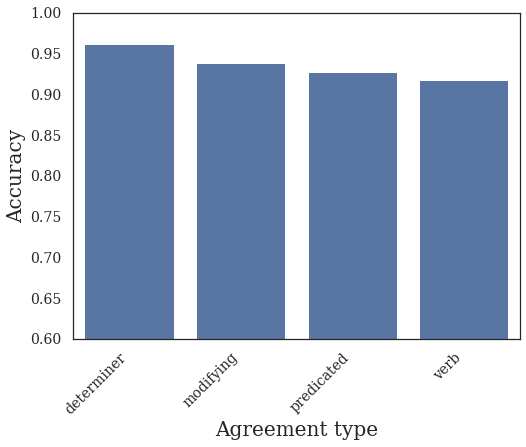

In [130]:
plot = barplot(results_by_type[results_by_type['right']], 'type', 'proportion', figsize=(8,6))
fontsize = 20
plt.xlabel("Agreement type", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.ylim((0.6, 1.0))
plt.tick_params(labelsize=14)

In [131]:
# Now we restrict to those above the threshold
results_by_type = (experiments.groupby('type')['right']
                   .value_counts(normalize=True)
                   .to_frame('proportion')
                   .reset_index())
results_by_type

,type,right,proportion
0,determiner,True,0.961282
1,determiner,False,0.038718
2,modifying,True,0.937837
3,modifying,False,0.062163
4,predicated,True,0.927176
5,predicated,False,0.072824
6,verb,True,0.917456
7,verb,False,0.082544


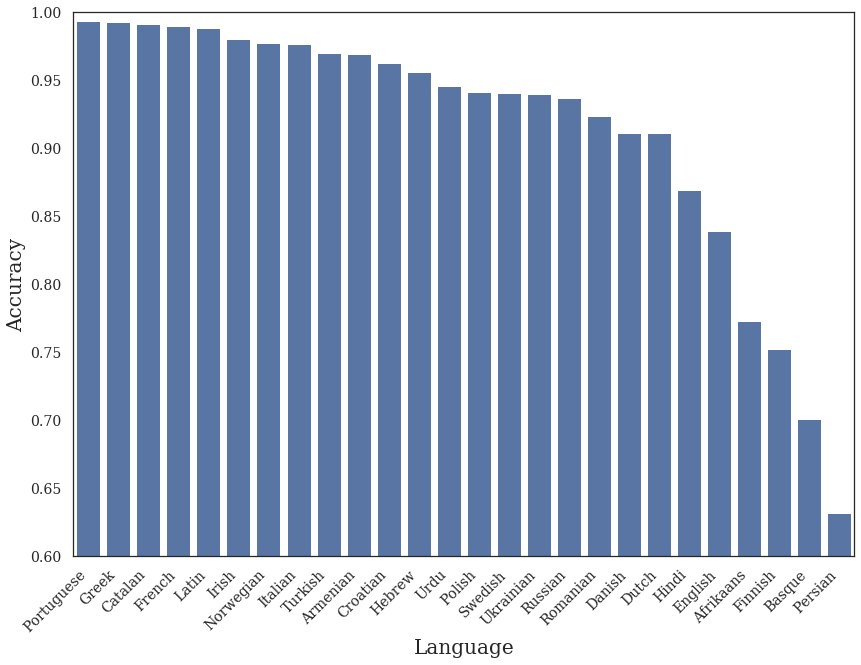

In [137]:
# 5. How well does BERT do on each language?
# There are so many languages that it's not as useful to look at the numbers themselves, so a plot it show instead
results_by_lg = (experiments.groupby('language')['right']
                   .value_counts(normalize=True)
                   .to_frame('proportion')
                   .reset_index())
results_by_lg.replace({"language": {"Norwegian-Nynorsk": "Norwegian"}}, inplace=True)
plot = barplot(results_by_lg[results_by_lg['right']], 'language', 'proportion', figsize=(14,10))
fontsize = 20
plt.xlabel("Language", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.ylim((0.6, 1.0))
plt.tick_params(labelsize=14)

In [133]:
# 6. What is the distribution of distance i) per type and ii) per language?
experiments['distance'].describe()

count    877713.000000
mean          3.052727
std           4.099899
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         157.000000
Name: distance, dtype: float64

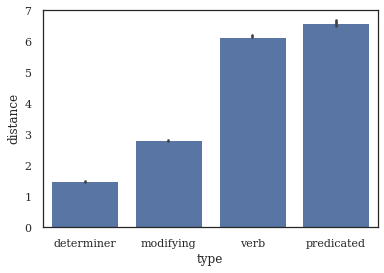

In [134]:
sns.barplot(x='type', y='distance', data=experiments, order=['determiner', 'modifying', 'verb', 'predicated'],
            color=BLUE);

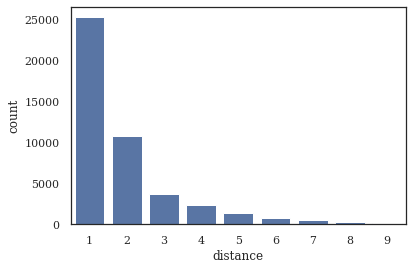

In [135]:
# Let's look at the distribution of distance for one language
def display_for(language, variable, high=10):
    """Convenience function for plotting distribution for one language."""
    lg = (experiments['language'] == language)
    hi = (experiments[variable] < high)
    low = (experiments[variable] > 0)
    subset = experiments[ lg & hi & low]
    sns.countplot(x=variable, data=subset, color=BLUE);

display_for('English', 'distance')

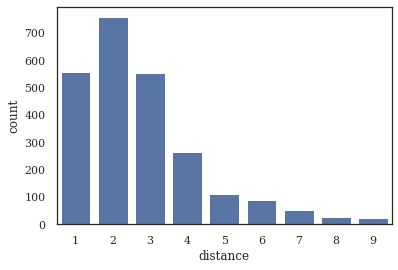

In [109]:
# Similar pattern for Turkish
display_for('Turkish', 'distance')

In [110]:
# 7. What is the distribution of number of distractors i) per type and ii) per language?
experiments['num_distractors'].describe()

count    877713.000000
mean          3.009233
std           2.557033
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          62.000000
Name: num_distractors, dtype: float64

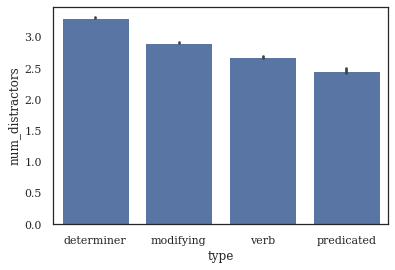

In [111]:
sns.barplot(x='type', y='num_distractors', data=experiments, order=['determiner', 'modifying', 'verb', 'predicated'],
            color=BLUE);

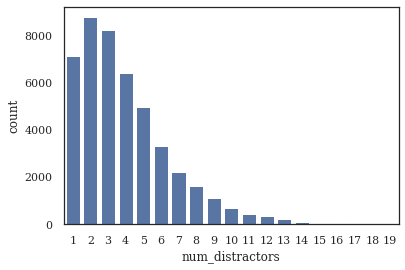

In [112]:
display_for('English', 'num_distractors', high=20)

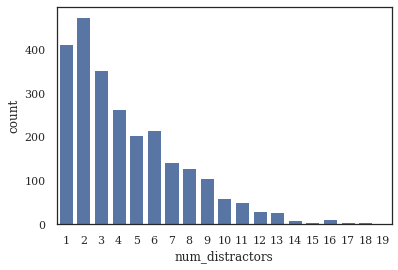

In [113]:
display_for('Turkish', 'num_distractors', high=20)

In [114]:
# Recode the 'right' column as 1's and 0's instead of True and False
experiments['right'] = experiments['right'].astype(int)

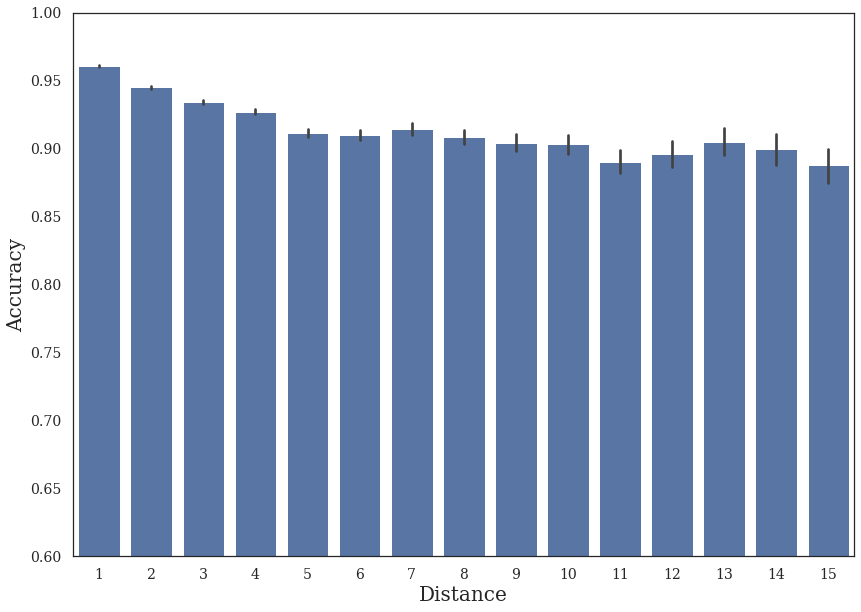

In [115]:
# 8. What is the relationship between BERT's performance and distance/number of distractors?
def plot_results(variable, high=10, figsize=(14, 10)):
    hi = (experiments[variable] <= high)
    low = (experiments[variable] > 0)
    df = experiments[hi & low]
    plt.figure(figsize=figsize)
    order = range(1, high+1)
    plot = sns.barplot(x=variable, y='right', data=df, color=BLUE, order=order);
    return plot

plot = plot_results('distance', high=15, figsize=(14,10))
fontsize = 20
plt.xlabel("Distance", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.ylim((0.6, 1.0))
plt.tick_params(labelsize=14)

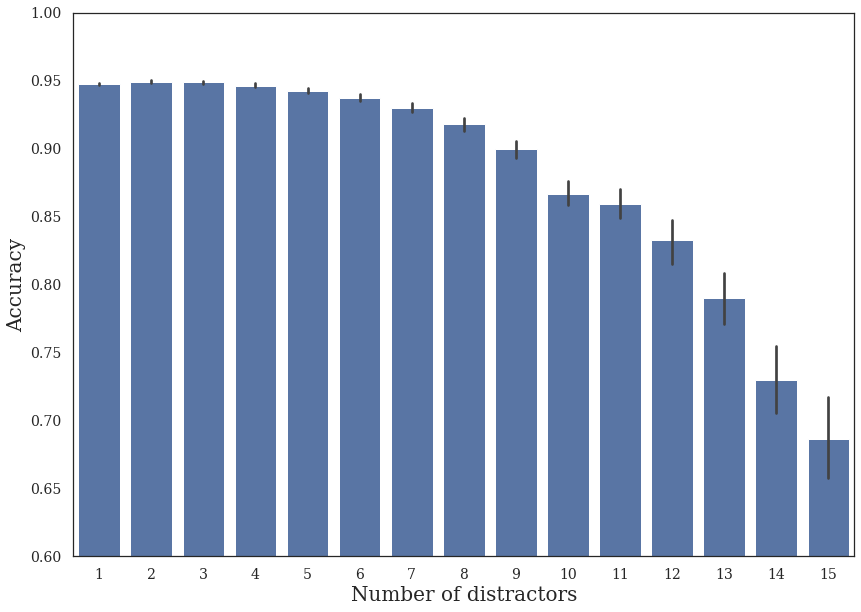

In [116]:
plot = plot_results('num_distractors', high=15, figsize=(14,10))
fontsize = 20
plt.xlabel("Number of distractors", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.ylim((0.6, 1.0))
plt.tick_params(labelsize=14)

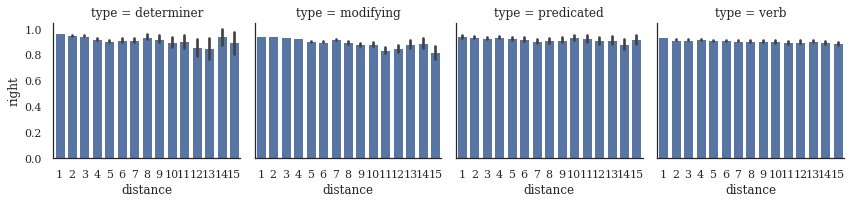

In [117]:
# Now we want to look at the relationship between performance and distance/distractors by type and by language
# We start with segmenting by type
def plot_results_by(by, variable, high=15, figsize=(14, 10)):
    hi = (experiments[variable] <= high)
    low = (experiments[variable] > 0)
    df = experiments[hi & low]
    order = range(1, high+1)
    col_order = sorted(experiments[by].unique())
    plot = sns.FacetGrid(data=df, col=by, col_wrap=4, col_order=col_order)
    plot = plot.map(sns.barplot, variable, 'right', color=BLUE, order=order);

plot_results_by('type', 'distance')

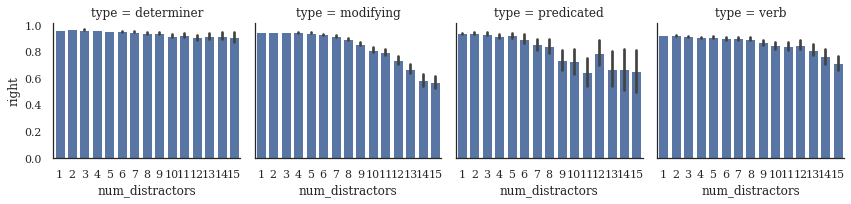

In [118]:
plot_results_by('type', 'num_distractors')

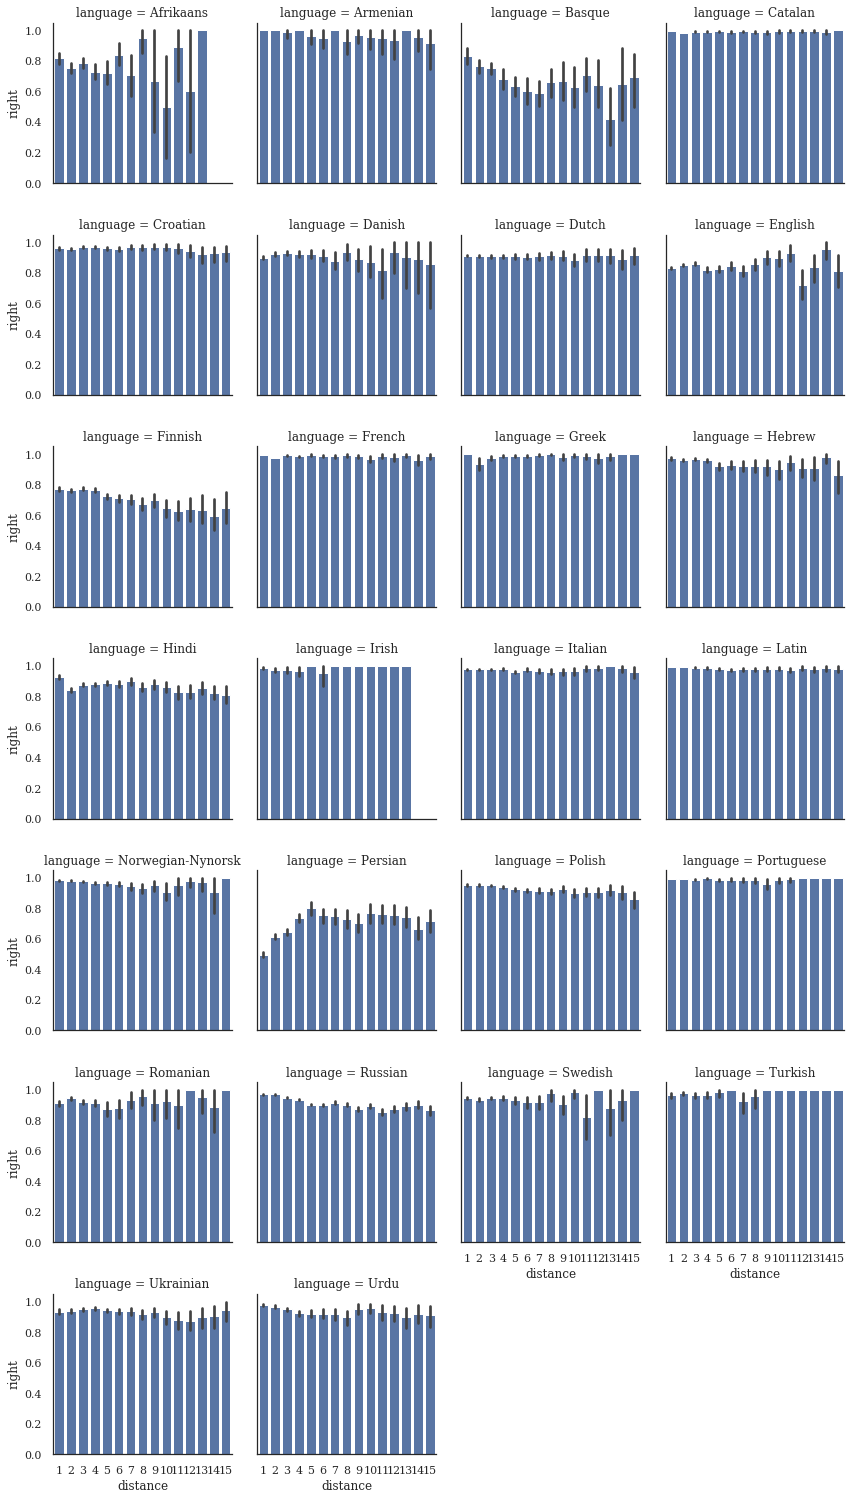

In [119]:
# Now we split by language
plot_results_by('language', 'distance')

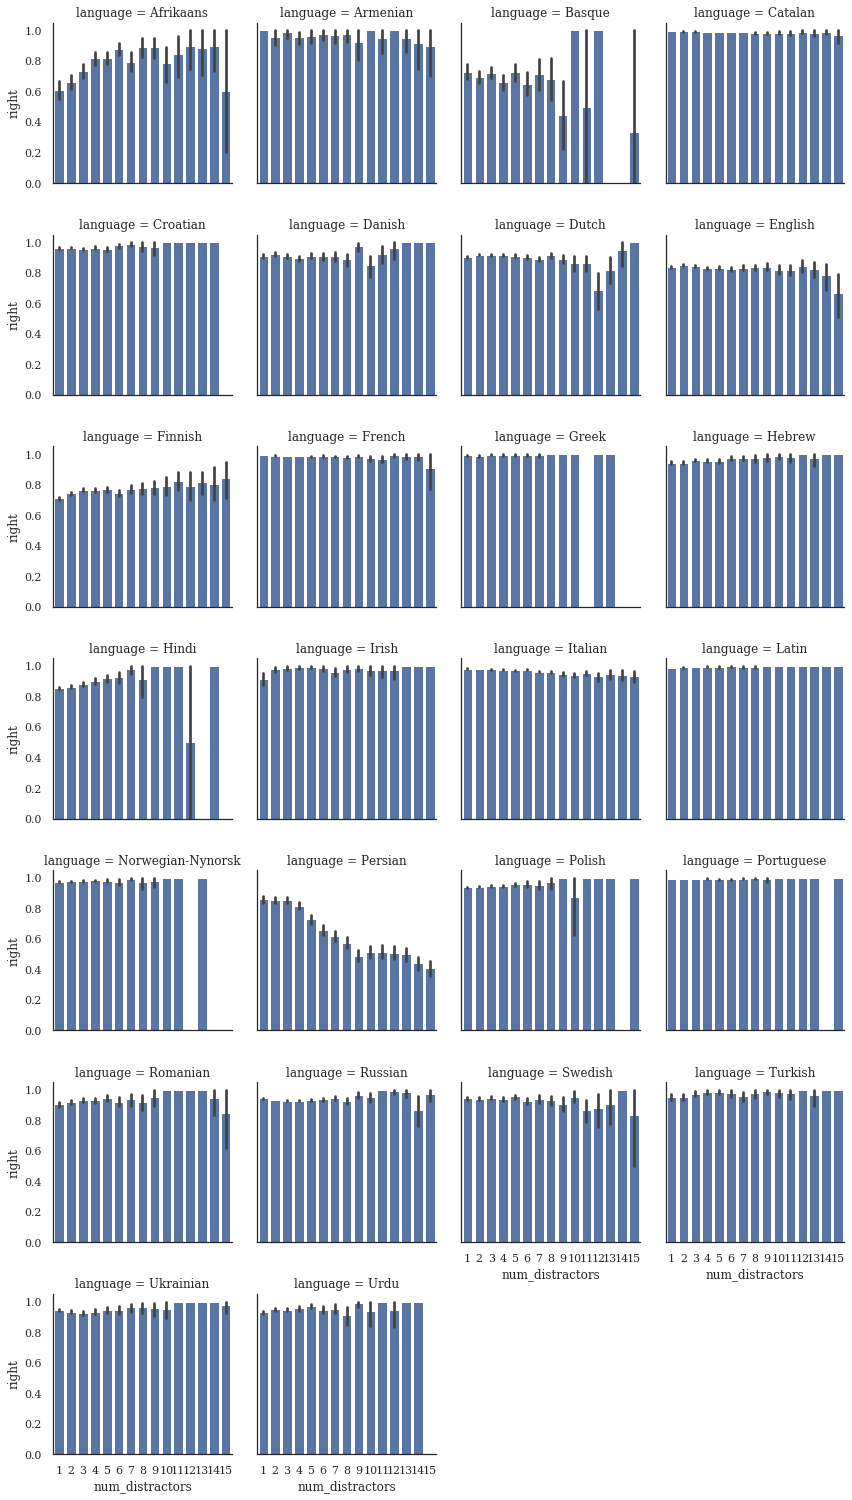

In [120]:
plot_results_by('language', 'num_distractors')